<a href="https://colab.research.google.com/github/luisespriella9/AI-DeepLearning-Course/blob/master/Evaluate_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Add AISP Class From File

In [1]:
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

class AISP:
  def __init__(self, timesteps, lstm_count = 7):
    self.train_dataset = None
    self.x_train = None
    self.timesteps = timesteps
    self.n_inputs = None
    self.scaler = None
    self.lstm_count = lstm_count

  def build_train_data(self, company, train_start_date, train_end_date):
    # build dataframe
    train_dataset = self.build_dataset(company, train_start_date, train_end_date)
    self.n_inputs = len(train_dataset.columns)
    self.train_dataset = train_dataset

    # convert to numpy
    training_set = train_dataset.iloc[:, :].values

    # scale data
    scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_training_set = scaler.fit_transform(training_set)
    self.scaler = scaler

    # build train data
    x_train = []
    y_train = []
    open_index = self.train_dataset.columns.get_loc("Open")
    for i in range(self.timesteps, len(scaled_training_set)):
        x_train.append(scaled_training_set[i-self.timesteps:i, :])
        y_train.append(scaled_training_set[i, open_index:open_index+1])
        
    x_train, y_train = np.array(x_train), np.array(y_train)

    # reshape data
    x_train = np.reshape(x_train, (x_train.shape[0], self.timesteps, self.n_inputs))
    self.x_train = x_train

    return x_train, y_train

  def build_prediction_data(self, company, test_start_date, test_end_date):
    test_dataset = self.build_dataset(company, test_start_date, test_end_date)

    #concatenate with training data
    dataset_total = pd.concat((self.train_dataset, test_dataset), axis = 0)
    dataset_total = dataset_total.fillna(method='ffill')
    dataset_total = dataset_total.fillna(method='bfill')

    # minimize data to timesteps size
    inputs = dataset_total[len(dataset_total)-len(test_dataset)-self.timesteps:].values
    #inputs = inputs.reshape(-1, 1) #set to right format
    #scale inputs
    inputs = self.scaler.transform(inputs)

    # build prediction data
    x_prediction = []
    for i in range(self.timesteps, self.timesteps+len(test_dataset)):
        x_prediction.append(inputs[i-self.timesteps:i, :])

    x_prediction = np.array(x_prediction)
    x_prediction = np.reshape(x_prediction, (x_prediction.shape[0], self.timesteps, self.n_inputs))
    return x_prediction

  def build_dataset(self, company, start_date, end_date):
    dataset = web.DataReader(company, "yahoo", start_date, end_date)
    dataset = dataset.drop(['Volume', 'High', 'Low', 'Close', 'Adj Close'], axis=1)
    inflation = web.DataReader(['CPILFESL'], 'fred', start_date, end_date)
    dataset = dataset.join(inflation)
    dataset = dataset.fillna(method='ffill')
    dataset = dataset.fillna(method='bfill')
    gdp = web.DataReader('GDP', 'fred', start_date, end_date)
    dataset = dataset.join(gdp)
    dataset = dataset.fillna(method='ffill')
    dataset = dataset.fillna(method='bfill')
    return dataset

  def inverse_transform(self, predicted_stock_price):
    y_scaler = MinMaxScaler()
    y_scaler.fit(self.train_dataset['Open'].values.reshape(-1, 1))
    return y_scaler.inverse_transform(predicted_stock_price)

  def build_rnn(self, n_inputs = None, units = 120, dropout_rate = 0.2, optimizer = 'adam', loss = 'mean_squared_error'):
    if (n_inputs == None):
      n_inputs = self.n_inputs
    regressor = Sequential()

    #add first LSTM layer and Dropout regularization
    first_lstm_layer = LSTM(units = units, return_sequences=True, input_shape = (self.x_train.shape[1], n_inputs), )
    regressor.add(first_lstm_layer)

    dropout_layer = Dropout(rate = dropout_rate)
    regressor.add(dropout_layer)

    if (self.lstm_count > 2):
      #Add lstm_count-1 more LSTM Layers
      for i in range(self.lstm_count-2):
        regressor.add(LSTM(units = units, return_sequences=True))
        regressor.add(Dropout(rate = dropout_rate))
      #last layer
      regressor.add(LSTM(units = units))
      regressor.add(Dropout(rate = dropout_rate))
    elif (self.lstm_count == 2):
      #first layer
      regressor.add(LSTM(units = units, return_sequences=True))
      regressor.add(Dropout(rate = dropout_rate))
      #second layer
      regressor.add(LSTM(units = units))
      regressor.add(Dropout(rate = dropout_rate))
    else:
      #modify first layer to not return sequences
      first_lstm_layer.return_sequences = False

    #add output layer
    output_layer = Dense(units = 1)
    regressor.add(output_layer)

    #compile RNN
    regressor.compile(optimizer = optimizer, loss = loss)
    return regressor

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


Build Train Data

In [0]:
#Train Data January 2020
company = "GOOG"
train_start_date = '2012-01-01'
train_end_date = '2018-01-01'
test_start_date = '2018-01-01'
test_end_date = '2018-02-01'

In [0]:
aisp = AISP(timesteps = 120, lstm_count = 8)

In [0]:
x_train, y_train = aisp.build_train_data(company, train_start_date, train_end_date)

Build and Fit RNN

In [0]:
regressor = aisp.build_rnn(units = 400, dropout_rate = 0.20, optimizer = 'adam', loss = 'mean_squared_error')

In [6]:
regressor.fit(x_train, y_train, epochs = 100, batch_size = 64)

Epoch 1/100
1389/1389 [==============================] - 74s 53ms/step - loss: 1.4098
Epoch 2/100
1389/1389 [==============================] - 72s 51ms/step - loss: 0.0157
Epoch 3/100
1389/1389 [==============================] - 73s 52ms/step - loss: 0.0038
Epoch 4/100
1389/1389 [==============================] - 73s 53ms/step - loss: 0.0028
Epoch 5/100
1389/1389 [==============================] - 74s 54ms/step - loss: 0.0028
Epoch 6/100
1389/1389 [==============================] - 73s 53ms/step - loss: 0.0024
Epoch 7/100
1389/1389 [==============================] - 72s 52ms/step - loss: 0.0027
Epoch 8/100
1389/1389 [==============================] - 71s 51ms/step - loss: 0.0028
Epoch 9/100
1389/1389 [==============================] - 72s 52ms/step - loss: 0.0028
Epoch 10/100
1389/1389 [==============================] - 72s 52ms/step - loss: 0.0022
Epoch 11/100
1389/1389 [==============================] - 73s 52ms/step - loss: 0.0022
Epoch 12/100
1389/1389 [============================

Build Prediction Data

In [0]:
x_prediction = aisp.build_prediction_data(company, test_start_date, test_end_date)

Predict January 2020

In [0]:

predicted_stock_price = regressor.predict(x_prediction)
predicted_stock_price = aisp.inverse_transform(predicted_stock_price)

Get Real January 2020 Stock Price

In [0]:
real_stock_price = aisp.build_dataset(company, test_start_date, test_end_date)['Open'].values


Visualize Results

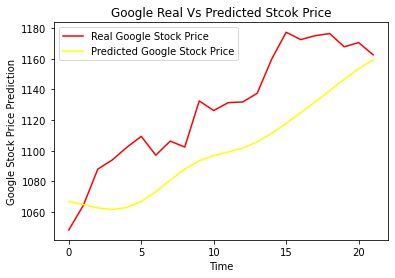

In [10]:
plt.plot(real_stock_price, color='red', label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='yellow', label='Predicted Google Stock Price')
plt.title('Google Real Vs Predicted Stcok Price')
plt.xlabel('Time')
plt.ylabel('Google Stock Price Prediction')
plt.legend()
plt.show()